In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, LeakyReLU

Init Plugin
Init Graph Optimizer
Init Kernel


In [87]:
from lightgbm import LGBMClassifier

In [3]:
fname = "./../data.npz"

In [4]:
data = np.load(fname, allow_pickle=True)

In [5]:
train_data = data["train"]

In [6]:
test_data = data["test"]

In [7]:
x_train = train_data[:, 0]
y_train = train_data[:, 1]

In [8]:
x_data = []
for i in range(x_train.shape[0]):
    x = x_train[i]
    x = x.flatten()
    x_data.append(x)

In [9]:
x_data = np.array(x_data)

In [10]:
x_data.shape

(5000, 1200)

In [11]:
x_data = np.asarray(x_data).astype('float32')

In [12]:
y_train = np.asarray(y_train).astype('float32')

## Train Test Split

In [13]:
x_tr, x_val, y_tr, y_val = train_test_split(x_data, y_train, test_size=0.2, stratify=y_train, random_state=99)

In [14]:
x_tr.shape

(4000, 1200)

In [15]:
x_val.shape

(1000, 1200)

## Scale data

In [20]:
scaler = StandardScaler()

In [21]:
scaler.fit(x_tr)

StandardScaler()

In [22]:
x_tr = scaler.transform(x_tr)

In [23]:
x_val = scaler.transform(x_val)

## Build Simple NN Model

In [78]:
input_size = 1200
hidden1 = 64
hidden2 = 32
classes = 1

In [79]:
model = Sequential()     
model.add(Dense(hidden1, input_dim=input_size))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(hidden2))
model.add(LeakyReLU(alpha=0.05))
model.add(Dense(classes, activation='sigmoid'))

In [80]:
# Compilation
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
              metrics=['accuracy'], 
              optimizer='adam')

In [81]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                76864     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 78,977
Trainable params: 78,977
Non-trainable params: 0
_________________________________________________________________


In [82]:
batch_size = 32
epch = 20

In [83]:
history = model.fit(x_data, y_train, 
                    validation_data=(x_val, y_val),
                    batch_size=batch_size,
                    epochs=epch,
                    verbose=1)

Epoch 1/20
 13/157 [=>............................] - ETA: 0s - loss: 0.3103 - accuracy: 0.8534 

2021-09-04 04:32:51.227241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 5ms/step - loss: 0.1062 - accuracy: 0.9656 - val_loss: 0.0822 - val_accuracy: 0.9740
Epoch 2/20
 12/157 [=>............................] - ETA: 0s - loss: 0.1205 - accuracy: 0.9714

2021-09-04 04:32:52.065560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 1s 5ms/step - loss: 0.0754 - accuracy: 0.9802 - val_loss: 0.0993 - val_accuracy: 0.9620
Epoch 3/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0704 - accuracy: 0.9794 - val_loss: 0.1061 - val_accuracy: 0.9610
Epoch 4/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0676 - accuracy: 0.9796 - val_loss: 0.1105 - val_accuracy: 0.9600
Epoch 5/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0619 - accuracy: 0.9824 - val_loss: 0.1979 - val_accuracy: 0.9400
Epoch 6/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0608 - accuracy: 0.9832 - val_loss: 0.1976 - val_accuracy: 0.9440
Epoch 7/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0639 - accuracy: 0.9824 - val_loss: 0.9604 - val_accuracy: 0.8920
Epoch 8/20
157/157 [==============================] - 1s 5ms/step - loss: 0.0615 - accuracy: 0.9830 - val_loss: 0.1555 - val_accuracy: 0.9510
Epoch 9/20
157/15

In [84]:
pdf = pd.DataFrame.from_dict(history.history)

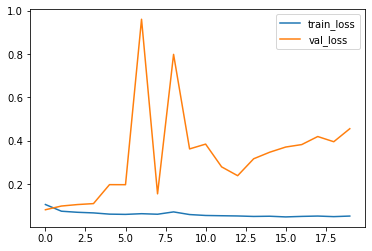

In [85]:
plt.plot(pdf["loss"], label="train_loss")
plt.plot(pdf["val_loss"], label="val_loss")
plt.legend()
plt.show()

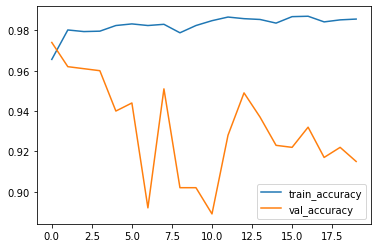

In [86]:
plt.plot(pdf["accuracy"], label="train_accuracy")
plt.plot(pdf["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()


In [41]:
y_val_pred = model.predict(x_val)

2021-09-04 04:01:28.361597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [43]:
roc_auc_score(y_val, y_val_pred)

0.8002142857142857

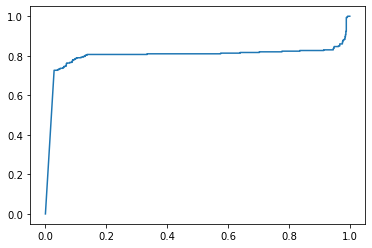

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)
plt.plot(fpr, tpr)
plt.show()

In [51]:
y_val_out = np.where(y_val_pred > 0.5, 1, 0)

In [52]:
f1_score(y_val, y_val_out)

0.7781456953642384

## Build Lightgbm model

In [90]:
x_tr_lgb, x_val_lgb, y_tr_lgb, y_val_lgb = train_test_split(x_data, y_train, test_size=0.2, stratify=y_train, random_state=99)

In [89]:
lgb_model = LGBMClassifier(learning_rate=0.01, n_estimators=300, reg_alpha=1.0, reg_lambda=0.5, random_state=99)

In [91]:
lgb_model.fit(x_tr_lgb, y_tr_lgb)

LGBMClassifier(learning_rate=0.01, n_estimators=300, random_state=99,
               reg_alpha=1.0, reg_lambda=0.5)

In [92]:
y_val_lgb_pred = lgb_model.predict(x_val_lgb)

In [93]:
roc_auc_score(y_val, y_val_lgb_pred)

0.9745238095238095

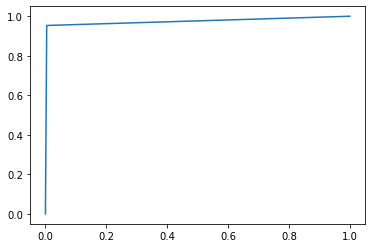

In [94]:
fpr, tpr, thresholds = roc_curve(y_val, y_val_lgb_pred)
plt.plot(fpr, tpr)
plt.show()

In [95]:
y_val_lgb_out = np.where(y_val_lgb_pred > 0.5, 1, 0)

In [96]:
f1_score(y_val, y_val_lgb_out)

0.9711375212224109

## Score NN Model

In [101]:
test_flat = []
for i in range(test_data.shape[0]):
    x = test_data[i]
    x = x.flatten()
    test_flat.append(x)

In [102]:
test_flat = np.array(test_flat)

In [103]:
test_flat = np.asarray(test_flat).astype('float32')

In [104]:
# x_test = scaler.transform(test_flat)

In [105]:
# scoring LGBM model
y_pred = lgb_model.predict(test_flat)

In [106]:
y_pred_out = np.where(y_pred > 0.5, 1, 0)

In [107]:
sdf = pd.read_csv("./../sample_submission.csv")

In [108]:
sdf.head()

,label
0,1
1,0
2,0
3,0
4,1


In [109]:
sdf["label"] = y_pred_out

In [110]:
sdf.to_csv("./assets/submission.csv", index=False)